## Working with local and remote datasets 

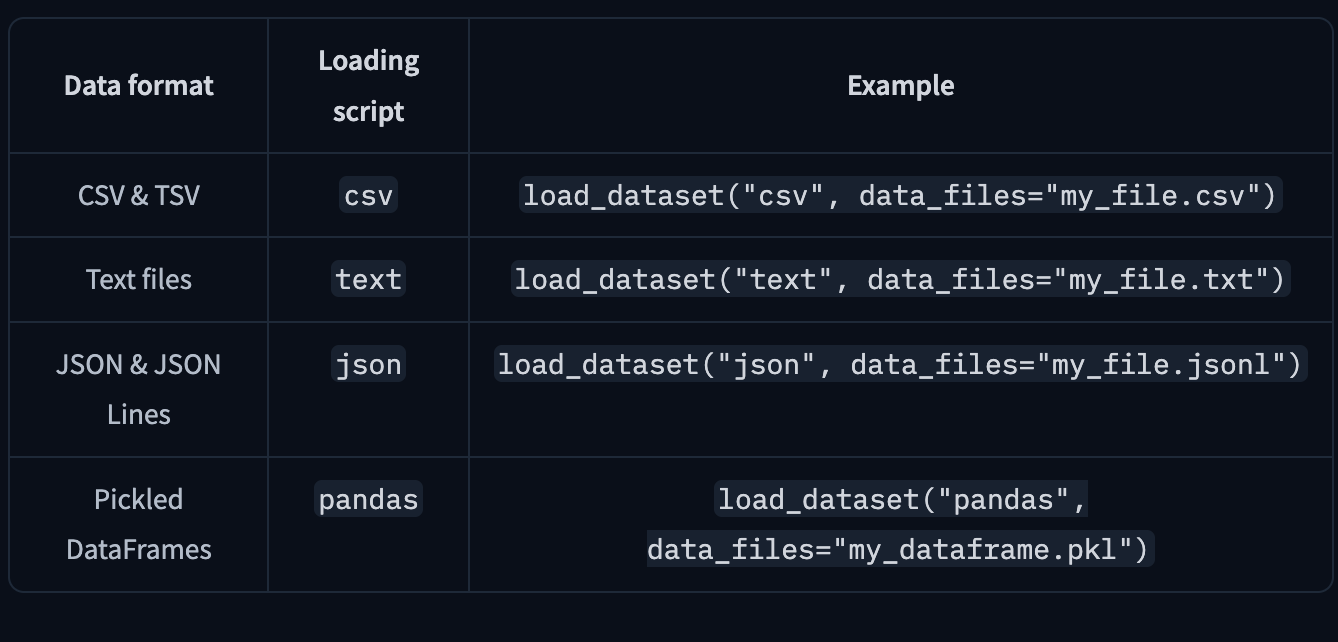

### Loading a local dataset

In [1]:
from datasets import load_dataset

movies_dataset = load_dataset("csv", data_files="Data/movies.csv")

movies_dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'budget', 'genres', 'homepage', 'id', 'keywords', 'original_language', 'original_title', 'overview', 'popularity', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'cast', 'crew', 'director'],
        num_rows: 4803
    })
})

### Loading from remote

In [ ]:
url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": url + "SQuAD_it-train.json.gz",
    "test": url + "SQuAD_it-test.json.gz",
}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

### Slicing and dicing our data

In [3]:
#download the dataset locally

!wget -P Data/ "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip Data/drugsCom_raw.zip -d Data

--2026-02-06 12:38:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘Data/drugsCom_raw.zip.1’

drugsCom_raw.zip.1      [    <=>             ]  41.00M  7.69MB/s    in 6.1s    

2026-02-06 12:38:48 (6.71 MB/s) - ‘Data/drugsCom_raw.zip.1’ saved [42989872]

Archive:  Data/drugsCom_raw.zip
replace Data/drugsComTest_raw.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Since TSV is just a variant of CSV that uses tabs instead of commas as the separator, we can load these files by using the csv loading script and specifying the delimiter argument in the load_dataset()

In [4]:
from datasets import load_dataset
data_files = {"train": "Data/drugsComTrain_raw.tsv", "test": "Data/drugsComTest_raw.tsv"}
drugs_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")
drugs_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In [5]:
# lets see a few examples
drug_sample = drugs_dataset['train'].shuffle(seed=42).select(range(1000))
drug_sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

In [6]:
for split in drugs_dataset.keys():
    assert len(drugs_dataset[split]) == len(drugs_dataset[split].unique('Unnamed: 0'))

In [7]:
drugs_dataset = drugs_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drugs_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In [10]:
# normalize all the conditions
def lowercase_condition(drug):
    if drug["condition"] is None:
        return {"condition": None}
    return {"condition": drug["condition"].lower()}

drugs_dataset.map(lowercase_condition)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In [11]:
# lets use a lambda function to clean drop the rows that are missing the conditions

drugs_dataset = drugs_dataset.filter(lambda x: x["condition"] is not None)

In [12]:
# lets normalize our condition column again

drugs_dataset = drugs_dataset.map(lowercase_condition)

drugs_dataset["train"]["condition"][:10]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['left ventricular dysfunction',
 'adhd',
 'birth control',
 'birth control',
 'opiate dependence',
 'benign prostatic hyperplasia',
 'emergency contraception',
 'bipolar disorde',
 'epilepsy',
 'birth control']

### Creating new columns
now we cleanup the review

In [13]:
def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

drugs_dataset = drugs_dataset.map(compute_review_length)
drugs_dataset["train"][0]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'patient_id': 206461,
 'drugName': 'Valsartan',
 'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27,
 'review_length': 17}

In [14]:
drugs_dataset['train'].sort('review_length')[:3]

{'patient_id': [111469, 13653, 53602],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse'],
 'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'rating': [10.0, 10.0, 10.0],
 'date': ['February 3, 2015', 'October 20, 2009', 'November 23, 2015'],
 'usefulCount': [41, 3, 0],
 'review_length': [1, 1, 1]}

In [16]:
# remove reviews that contain fewer than 30 characters. 
drugs_dataset = drugs_dataset.filter(lambda x: x["review_length"] > 30)
print(drugs_dataset.num_rows)

Filter:   0%|          | 0/158429 [00:00<?, ? examples/s]

Filter:   0%|          | 0/52825 [00:00<?, ? examples/s]

{'train': 138514, 'test': 46108}


In [17]:
# remove html characters from the code
import html
drugs_dataset = drugs_dataset.map(lambda x: {"review": html.unescape(x["review"])});

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples['review'], truncation=True)

In [30]:
slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)

def slow_tokenize_function(examples):
    return slow_tokenizer(examples["review"], truncation=True)

tokenized_dataset = drugs_dataset.map(slow_tokenize_function, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/138514 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/46108 [00:00<?, ? examples/s]

In [31]:
# deal with mismatched length problem
def tokenize_and_split(examples):
    result = tokenizer(
        examples['review'],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )

    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

In [34]:
tokenized_dataset = drugs_dataset.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]